## Testing deconvolution techniques: a guide ##

This document shows how to test deconvolution techniques on simulated data and how to use some of the simulation and testing tools developed as part of the [uvcombine](https://github.com/radio-astro-tools/uvcombine) project

In [1]:
# ipython notebook setup:
%matplotlib inline

In [2]:
# import modules:
import image_registration
from astropy import convolution
import numpy as np
import pylab as pl

# deconvolve using skimage techniques
from skimage.restoration import unsupervised_wiener, richardson_lucy, wiener

# change the default colorscheme:
pl.rcParams['image.cmap'] = 'viridis'

Create the synthetic image and have a look at it:

In [3]:
np.random.seed(0)
im = image_registration.tests.make_extended(imsize=256, powerlaw=1.5)

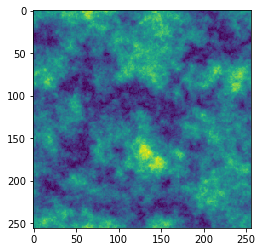

In [4]:
pl.imshow(im)

In [5]:
singledish_kernel = convolution.Gaussian2DKernel(40/2.35, x_size=256, y_size=256)
singledish_kernel_fft = np.fft.fft2(singledish_kernel)

singledish_im = convolution.convolve_fft(im,
                                         convolution.Gaussian2DKernel(40/2.35),
                                         boundary='fill', fill_value=im.mean())

The kernel:

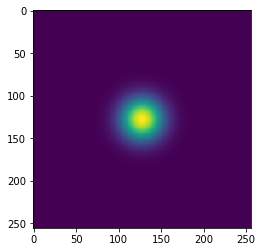

In [6]:
pl.imshow(singledish_kernel)

Its fourier transform:

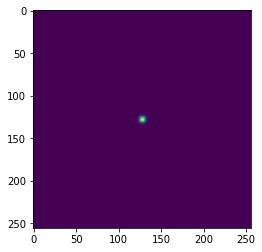

In [7]:
pl.imshow(np.abs(np.fft.fftshift(singledish_kernel_fft)))

The convolved image side-by-side with the unconvolved:

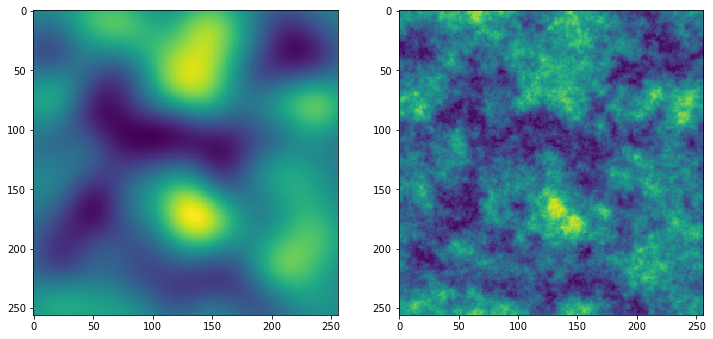

In [8]:
pl.figure(figsize=(12,6))
pl.subplot(1,2,1)
pl.imshow(singledish_im)
pl.subplot(1,2,2)
pl.imshow(im)

### First attempt: Fourier-space deconvolution###

This approach is the most literal and naive approach, but to work it requires nearly infinite signal-to-noise.

The general idea is that convolution is simply multiplication between a kernel and an image in the Fourier domain.  Deconvolution is therefore *division* of the image by the kernel in the fourier domain.

The problem, which is dealt with below, is that the kernel rapidly drops to zero, which means the convolution zero'd out the signal at large wavenumbers.  The deconvolution therefore becomes approximately zero-divided-by-zero.  This necessitates cropping the kernel before dividing in fourier space, otherwise you get a divergent result.  The net result is not very good:

In [9]:
# deconvolve in fourier space
# This "works", but requires that you set a limit on where you perform the
# fourier-space division that is pretty arbitrary / empirical, otherwise you
# just get junk out.
deconv_kernel = singledish_kernel_fft.copy()
badpix = np.abs(deconv_kernel) < 1e-1
imfft = np.fft.fft2(im)
naive_deconvolution_fft = (imfft / deconv_kernel)
naive_deconvolution_fft[badpix] = imfft[badpix]
naive_deconvolution = np.fft.ifft2(naive_deconvolution_fft)

/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/orange/adamginsburg/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


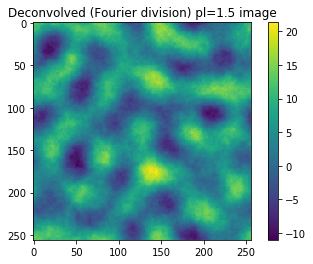

In [10]:
pl.clf()
pl.imshow(np.fft.fftshift(naive_deconvolution.real), cmap='viridis')
pl.colorbar()
pl.title("Deconvolved (Fourier division) pl=1.5 image")
pl.savefig("fourierdivisiondeconvolve_singledish_image_pl1.5.png")

### Second attempt: Unsupervised Wiener deconvolution ###

I don't know much about [Weiner deconvolution](https://en.wikipedia.org/wiki/Wiener_deconvolution) but Sandra recommended trying it.

It doesn't work.  Maybe there is some set of parameters that can make it work better, or maybe there is a better implementation, but I haven't found it yet.

In [11]:
# setup
# we have to normalize the image & kernel to use skimage tools
sd_min = singledish_im.min()
sd_range = (singledish_im.max() - sd_min)
singledish_scaled = (singledish_im - sd_min) / sd_range
norm_kernel = singledish_kernel.array/singledish_kernel.array.max()

In [12]:
# Use skimage for the deconvolution

# note that for skimage, it is critical that clip=False be specified!

# Wiener deconvolution is some sort of strange Bayesian approach.  It works
# great on "real" photos of people, but doesn't work at all on our data
wienered_singledish,chain = unsupervised_wiener(image=singledish_scaled,
                                                psf=norm_kernel,
                                                clip=False,
                                                user_params=dict(max_iter=1000,
                                                                 burnin=100,
                                                                 min_iter=100,
                                                                 threshold=1e-5),)

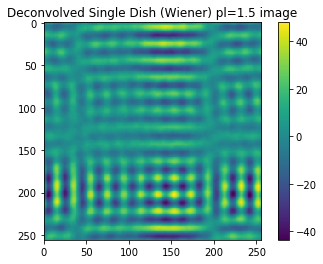

In [13]:
pl.clf()
pl.imshow(wienered_singledish*sd_range+sd_min, cmap='viridis')
pl.colorbar()
pl.title("Deconvolved Single Dish (Wiener) pl=1.5 image")
pl.savefig("wienerdeconvolve_singledish_image_pl1.5.png")

### Third Attempt: Lucy-Richardson Deconvolution ###

[This method](https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution) is commonly used in the optical.


Edge effects can be eliminated by padding with the mean of the image (which will usually be zero).

The speed can be a problem, but optimizations - perhaps using [dask](https://github.com/dask/dask-image/issues/149) - are possible

In [14]:
# Lucy-Richardson/Richardson-Lucy is an iterative, fourier-based approach.
# It is slow.  It looks like it works fine.
lucyrichardson_singledish = richardson_lucy(np.pad(singledish_scaled, 100, constant_values=singledish_scaled.mean()), norm_kernel,
                                            iterations=20, clip=False)[100:-100,100:-100]

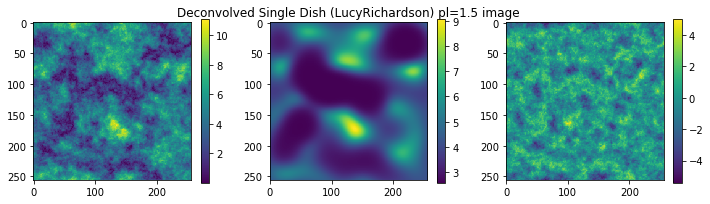

In [15]:
pl.figure(figsize=(12,3))
im_ = pl.subplot(1,3,1).imshow(im, cmap='viridis')
pl.colorbar(im_)
im_ = pl.subplot(1,3,2).imshow(lucyrichardson_singledish*sd_range+sd_min, cmap='viridis')
pl.colorbar(im_)
pl.title("Deconvolved Single Dish (LucyRichardson) pl=1.5 image")
im_ = pl.subplot(1,3,3).imshow(lucyrichardson_singledish*sd_range+sd_min - im, cmap='viridis')
pl.colorbar(im_)
pl.savefig("lucyrichardsondeconvolve_singledish_image_pl1.5.png")

In [16]:
lucyrichardson_singledish_100 = richardson_lucy(np.pad(singledish_scaled, 100, constant_values=singledish_scaled.mean()), norm_kernel,
                                            iterations=100, clip=False)[100:-100,100:-100]

Text(0.5, 1.0, 'Lucy-Richardson 100 iters')

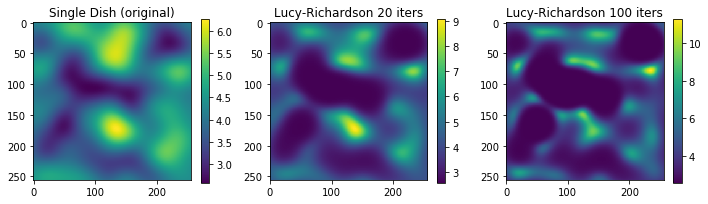

In [17]:
pl.figure(figsize=(12,3))
im_ = pl.subplot(1,3,1).imshow(singledish_im, cmap='viridis')
pl.colorbar(im_)
pl.title("Single Dish (original)")
im_ = pl.subplot(1,3,2).imshow(lucyrichardson_singledish*sd_range+sd_min, cmap='viridis')
pl.colorbar(im_)
pl.title("Lucy-Richardson 20 iters")
im_ = pl.subplot(1,3,3).imshow(lucyrichardson_singledish_100*sd_range+sd_min, cmap='viridis')
pl.colorbar(im_)
pl.title("Lucy-Richardson 100 iters")

### Wiener deconvolution

This just looks bad.

In [18]:
sup_wienered_singledish = wiener(image=singledish_scaled,
                                   psf=norm_kernel,
                                   balance=1., clip=False)

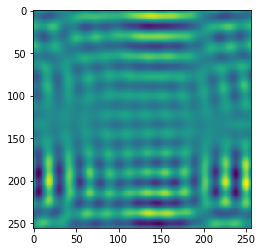

In [19]:
pl.imshow(sup_wienered_singledish)

### Additional Ideas ###

Single-dish "clean" is usually pretty good, but there aren't any implementations in skimage.  We could try using [Aaron Parson's deconvolution tools](https://github.com/AaronParsons/aipy/blob/9f530c2a715d52977295bb776d0ebf01a9630254/src/deconv.py), which I have found effective in the past, but I think we'd need to reimplement parts of them if we want to distribute the code.  Or maybe we could get them incorporated into astropy...

Other modules to keep an eye on:

https://github.com/alexis-mignon/pydeconv and related https://www.mrao.cam.ac.uk/~bn204/alma/python-clean.html